In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\bradl\AppData\Local\Temp\ipykernel_21796\945324820.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv(r'C:\Users\bradl\OneDrive\Desktop\Final_Project_ML_Slender\Cleaned_Datasets\2021_CostReport_Clean.csv')

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15057 entries, 0 to 15056
Data columns (total 80 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   rpt_rec_num                                                       15057 non-null  int64  
 1   Provider CCN                                                      15057 non-null  int64  
 2   Facility Name                                                     15057 non-null  object 
 3   Street Address                                                    15057 non-null  object 
 4   City                                                              15057 non-null  object 
 5   State Code                                                        15057 non-null  object 
 6   Zip Code                                                          15057 non-null  object 
 7   County                         

In [5]:
print(df['Less Total Operating Expense'].mean())
print(df['Net Patient Revenue'].mean())

10386540.925815236
9201937.407982998


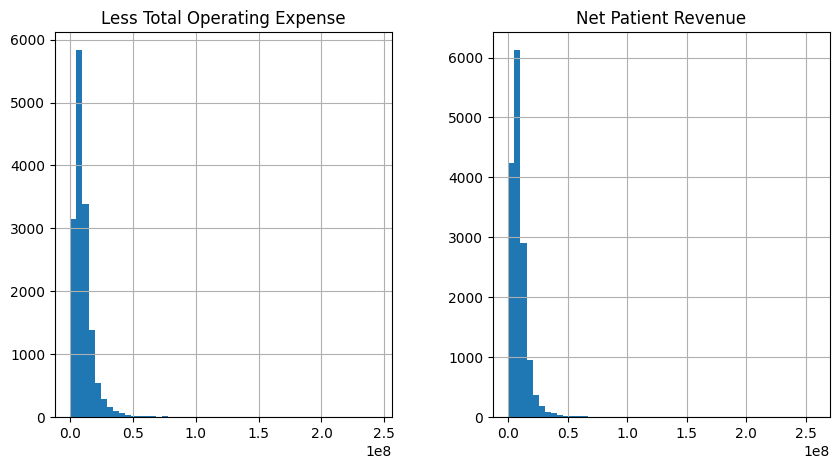

In [6]:
df[['Less Total Operating Expense', 'Net Patient Revenue']].hist(bins=50, figsize=(10,5))
plt.show() #before removing outliers

In [7]:
Q1 = df['Less Total Operating Expense'].quantile(0.25)
Q3 = df['Less Total Operating Expense'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Less Total Operating Expense'] >= lower_bound) & (df['Less Total Operating Expense'] <= upper_bound)]

Q1_npr = df['Net Patient Revenue'].quantile(0.25)
Q3_npr = df['Net Patient Revenue'].quantile(0.75)
IQR_npr = Q3_npr - Q1_npr

lower_bound_npr = Q1_npr - 1.5 * IQR_npr
upper_bound_npr = Q3_npr + 1.5 * IQR_npr

df = df[(df['Net Patient Revenue'] >= lower_bound_npr) & (df['Net Patient Revenue'] <= upper_bound_npr)]

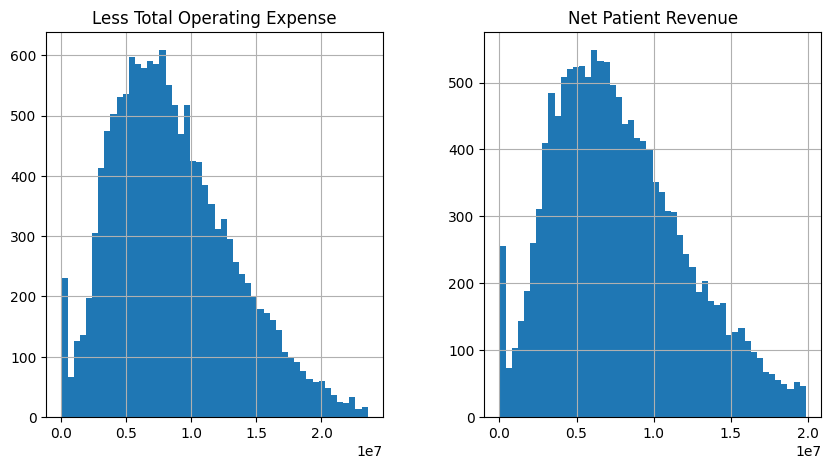

In [8]:
df[['Less Total Operating Expense', 'Net Patient Revenue']].hist(bins=50, figsize=(10,5))
plt.show() #after removing outliers

In [9]:
df['ROI'] = (df['Net Patient Revenue'] - df['Less Total Operating Expense']) / df['Less Total Operating Expense'] * 100

df = df[df['ROI'] >= 0]

df['ROI_Target'] = df['ROI'] > df['ROI'].quantile(0.70)

label_dict = {True: 1, False: 0}

df['ROI_Target'] = df['ROI_Target'].map(label_dict)

In [10]:
df['ROI']

0        12.244700
3         8.151023
5        12.059095
8        49.555393
12       14.106034
           ...    
15038    29.776745
15044     6.433301
15047     0.952125
15054    22.856293
15056     4.770857
Name: ROI, Length: 3710, dtype: float64

In [11]:
new_df = df.select_dtypes(include=None, exclude=['object'])
new_df.isnull().mean()*100
new_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3710 entries, 0 to 15056
Data columns (total 73 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   rpt_rec_num                                                       3710 non-null   int64  
 1   Provider CCN                                                      3710 non-null   int64  
 2   Medicare CBSA Number                                              3710 non-null   float64
 3   Type of Control                                                   3710 non-null   float64
 4   Total Days Title XVIII                                            3710 non-null   float64
 5   Total Days Title XIX                                              3710 non-null   float64
 6   Total Days Other                                                  3710 non-null   float64
 7   Total Days Total                     

In [12]:
X = new_df.drop(['Less Total Operating Expense', 'Net Patient Revenue', 'ROI', 'ROI_Target'], axis=1)
y = new_df['ROI_Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
rf_grid = {'max_depth': [2,3,4,5,6],
           'min_samples_leaf': [0.015, 0.02, 0.025, 0.03, 0.035, 0.05],
           'n_estimators': [10, 50, 60, 100]}

rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_grid, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
print("Train Score", rf.score(X_train, y_train))
print("Test Score", rf.score(X_test, y_test))
print("Best Parameters", rf.best_params_)
print("Features", rf.best_estimator_.feature_importances_)


Train Score 0.9309299191374663
Test Score 0.9164420485175202
Best Parameters {'max_depth': 6, 'min_samples_leaf': 0.015, 'n_estimators': 100}
Features [2.62423545e-03 8.84242198e-03 2.73241186e-03 2.39872176e-03
 1.32971168e-03 1.21401343e-03 5.11843964e-03 8.80009817e-03
 1.63198739e-03 4.54419255e-03 5.89920230e-04 5.20460642e-04
 2.40421524e-03 9.39772594e-04 1.63718832e-03 8.79089340e-04
 1.09559438e-04 1.16394508e-03 5.43790442e-04 1.32334362e-03
 2.32402810e-03 2.91537836e-03 1.69112976e-03 5.68327172e-03
 8.94288575e-03 2.62518786e-03 3.85976482e-03 5.06224338e-04
 1.28189650e-03 2.24787139e-03 1.96874304e-03 1.23798390e-02
 2.57665146e-02 1.19458515e-03 3.03209399e-03 1.19793821e-02
 1.26062764e-02 7.61904608e-03 4.24882738e-03 2.02283151e-03
 2.84818306e-04 9.08353858e-04 8.82394681e-03 1.09417887e-03
 2.06853907e-03 3.15764176e-03 3.47488588e-03 1.29773800e-03
 5.51123952e-03 2.07673925e-03 2.75585037e-03 2.69166505e-03
 7.91414661e-04 1.15961040e-03 6.16277892e-04 1.33817099

In [14]:
feature_names = X.columns
feature_importances = rf.best_estimator_.feature_importances_

for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")

rpt_rec_num: 0.00262423544557842
Provider CCN: 0.008842421982850653
Medicare CBSA Number: 0.0027324118585304235
Type of Control: 0.002398721755188547
Total Days Title XVIII: 0.0013297116823508556
Total Days Title XIX: 0.0012140134314890664
Total Days Other: 0.005118439640112093
Total Days Total: 0.008800098165035946
Number of Beds: 0.0016319873913384652
Total Bed Days Available: 0.004544192545960974
Total Discharges Title XVIII: 0.0005899202300230165
Total Discharges Title XIX: 0.0005204606424099974
Total Discharges Title Other: 0.0024042152403918856
Total Discharges Total: 0.0009397725943165164
SNF Average Length of Stay Title XVIII: 0.0016371883176668045
SNF Average Length of Stay Title XIX: 0.0008790893404749722
SNF Average Length of Stay Total: 0.00010955943774356908
SNF Admissions Title XVIII: 0.0011639450757830543
SNF Admissions Title XIX: 0.0005437904419047597
SNF Admissions Other: 0.001323343621911174
SNF Admissions Total: 0.002324028103664073
SNF Days Title XVIII: 0.0029153783

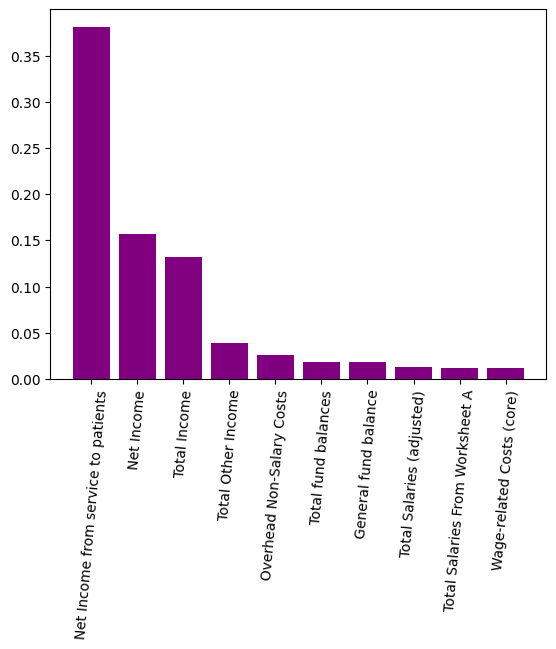

In [15]:
f_importances = pd.Series(rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.bar(f_importances.index, height=f_importances, color='purple')
plt.xticks(rotation=85)
plt.show()

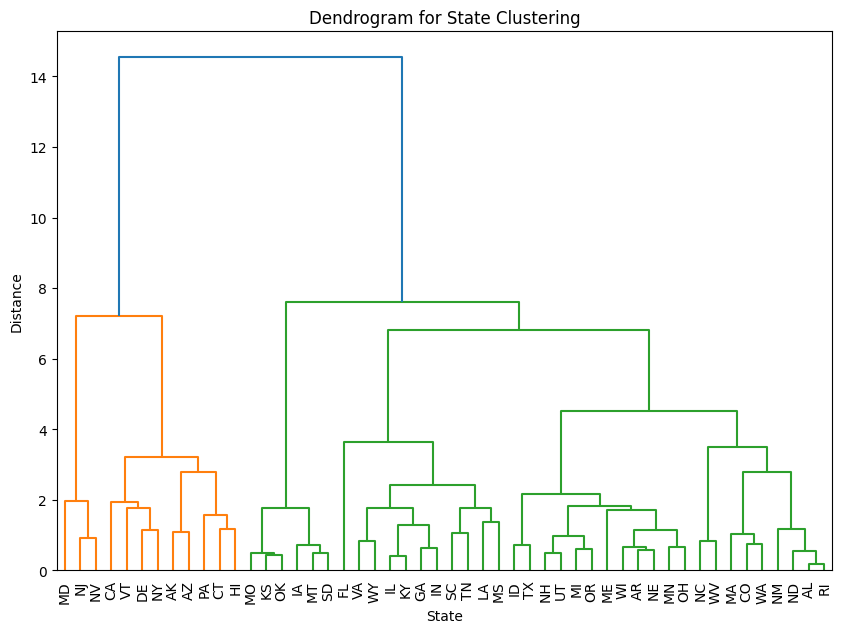

In [16]:
relevant_columns = ['State Code', 'Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Allowable Bad Debts', 'Inpatient PPS Amount']
filtered_data = df[relevant_columns].dropna()
state_aggregated_data = filtered_data.groupby('State Code').mean().reset_index()

# Data standardization and clustering with Ward's method
scaler = StandardScaler()
scaled_features = scaler.fit_transform(state_aggregated_data.iloc[:, 1:])
linkage_matrix = linkage(scaled_features, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linkage_matrix,
    labels=state_aggregated_data['State Code'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None,
)
plt.title('Dendrogram for State Clustering')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

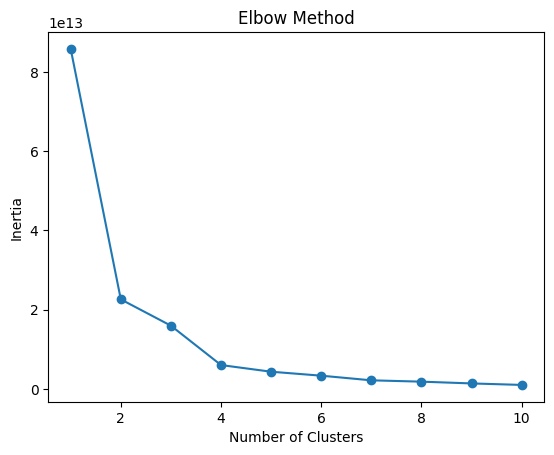

In [32]:
# Clustering the states
inertia = []

k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [33]:
relevant_columns = ['State Code', 'Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Allowable Bad Debts', 'Inpatient PPS Amount']
new_df = df[relevant_columns].copy()

In [38]:
Z = linkage(new_df.iloc[:, 1:], method='ward')

clusters = fcluster(Z, 4, criterion='maxclust')
cluster_states = {}
 
#connecting states to corresponding clusters
for state, cluster in zip(df['State Code'], clusters):
    if cluster not in cluster_states:
        cluster_states[cluster] = []
    cluster_states[cluster].append(state)
 
#display states
for cluster, states in cluster_states.items():
    print(f"Cluster {cluster}: {states}")

unique_states_per_cluster = cluster_data.drop_duplicates(subset='State Code')
unique_states_per_cluster

Cluster 2: ['NH', 'MT', 'OK', 'MT', 'WA', 'TX', 'LA', 'TX', 'IL', 'KY', 'MI', 'TX', 'LA', 'TX', 'TX', 'CT', 'NJ', 'NC', 'TX', 'TX', 'TX', 'TX', 'TX', 'IL', 'IN', 'MI', 'MA', 'IL', 'TX', 'LA', 'MN', 'MN', 'MN', 'TX', 'TX', 'NM', 'TX', 'VA', 'ID', 'KY', 'NC', 'WV', 'GA', 'GA', 'TX', 'NC', 'MO', 'NC', 'TX', 'TX', 'AR', 'TX', 'SC', 'TX', 'TX', 'MO', 'OH', 'TX', 'AR', 'IN', 'MA', 'SD', 'KS', 'WA', 'TX', 'MO', 'TX', 'TX', 'FL', 'NE', 'SD', 'TX', 'IN', 'MA', 'MO', 'IA', 'KS', 'TX', 'MA', 'KS', 'KS', 'MA', 'TX', 'TX', 'TX', 'MO', 'AK', 'VA', 'TX', 'MO', 'KY', 'TX', 'CO', 'MO', 'TN', 'CA', 'IA', 'MO', 'TX', 'WI', 'WI', 'NC', 'CO', 'MO', 'OH', 'OH', 'WA', 'IA', 'VA', 'CO', 'TX', 'TX', 'AR', 'TX', 'TX', 'IN', 'IN', 'OK', 'TX', 'TX', 'TX', 'IN', 'OH', 'IA', 'TX', 'TX', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'TX', 'TX', 'OK', 'TX', 'TX', 'TX', 'CA', 'ID', 'ID', 'KS', 'KS', 'OK', 'UT', 'TX', 'LA', 'OK', 'OK', 'ID', 'ID', 'KS', 'KS', 'SD', 'TX', 'AR', 'MN', 'TX', 'TX', 'AR', 'GA', 'IL', 'IA'

,State Code,Net Patient Revenue,Less Total Operating Expense,Net Income from service to patients,Inpatient PPS Amount
1,AL,1.029692e+07,9.759186e+06,5.377301e+05,1.405234e+06
2,AR,7.383538e+06,6.920360e+06,4.631784e+05,1.746079e+06
5,CO,9.282902e+06,8.664916e+06,6.179862e+05,2.378647e+06
8,FL,1.114572e+07,1.059625e+07,5.494676e+05,3.510169e+06
9,GA,9.356021e+06,8.679422e+06,6.765997e+05,1.774254e+06
12,ID,7.050565e+06,6.279513e+06,7.710515e+05,1.326127e+06
13,IL,7.949690e+06,7.264559e+06,6.851305e+05,2.153601e+06
14,IN,9.327549e+06,8.540246e+06,7.873029e+05,1.846477e+06
16,KY,7.852949e+06,7.227130e+06,6.258193e+05,1.765971e+06
17,LA,8.777329e+06,7.983272e+06,7.940567e+05,1.857044e+06


In [39]:
# Determining clusters and creating a composite risk score
num_clusters = 4
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
state_aggregated_data['Cluster'] = clusters


In [27]:
# Aggregating additional variables for the composite risk score
selected_variables = ['Net Income from service to patients', 'Less Total Operating Expense', 'Allowable Bad Debts', 'Net Patient Revenue', 'Inpatient PPS Amount']
state_data_for_risk_score = df.groupby('State Code')[selected_variables].mean().reset_index()
state_data_for_risk_score

,State Code,Net Income from service to patients,Less Total Operating Expense,Allowable Bad Debts,Net Patient Revenue,Inpatient PPS Amount
0,AK,1.273436e+06,1.226648e+07,68041.333333,1.353992e+07,2.676564e+06
1,AL,5.377301e+05,9.759186e+06,21282.380282,1.029692e+07,1.405234e+06
2,AR,4.631784e+05,6.920360e+06,6386.339623,7.383538e+06,1.746079e+06
3,AZ,1.245762e+06,1.077977e+07,28955.886792,1.202553e+07,3.130530e+06
4,CA,1.061747e+06,1.054384e+07,16676.481840,1.160558e+07,4.578318e+06
5,CO,6.179862e+05,8.664916e+06,70495.135135,9.282902e+06,2.378647e+06
6,CT,6.324305e+05,1.179409e+07,13827.192308,1.242652e+07,2.758600e+06
7,DE,7.481162e+05,1.327490e+07,30598.916667,1.402302e+07,3.372424e+06
8,FL,5.494676e+05,1.059625e+07,389282.000000,1.114572e+07,3.510169e+06
9,GA,6.765997e+05,8.679422e+06,195254.544444,9.356021e+06,1.774254e+06


In [20]:
scaled_features_for_risk_score = scaler.fit_transform(state_data_for_risk_score[selected_variables])
revised_weights = [-0.25, 0.2, 0.2, -0.25, -0.1]
revised_risk_scores = scaled_features_for_risk_score.dot(revised_weights) 
state_data_for_risk_score['Revised Risk Score'] = revised_risk_scores

# Linear regression models for each cluster
models = {}
performance = {}
for cluster_num in range(1, 5):
    states_in_cluster = state_aggregated_data[state_aggregated_data['Cluster'] == cluster_num]['State Code']
    cluster_data = state_data_for_risk_score[state_data_for_risk_score['State Code'].isin(states_in_cluster)]
    
    X = cluster_data[['Net Patient Revenue', 'Less Total Operating Expense', 'Allowable Bad Debts']]
    y = cluster_data['Revised Risk Score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    models[f'Cluster {cluster_num}'] = model
    performance[f'Cluster {cluster_num}'] = {'MSE': mse, 'R-squared': r2}

print("MSE: ", mse)
print("R-squared: ", r2)

MSE:  0.003101034774990127
R-squared:  0.968777540313209


C:\Users\bradl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [21]:
centroids = state_aggregated_data.groupby('Cluster')[['Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Inpatient PPS Amount']].mean().reset_index()
closest_states = {}
for cluster_num in range(1, 5):
    centroid = centroids[centroids['Cluster'] == cluster_num].iloc[:, 1:].values
    cluster_data = state_aggregated_data[state_aggregated_data['Cluster'] == cluster_num][['State Code', 'Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Inpatient PPS Amount']]
    
    distances = cdist(cluster_data.iloc[:, 1:], centroid, 'euclidean')
    closest_state_index = distances.argmin()
    closest_state = cluster_data.iloc[closest_state_index]
    
    closest_states[f'Cluster {cluster_num}'] = closest_state


centroids


,Cluster,Net Patient Revenue,Less Total Operating Expense,Net Income from service to patients,Inpatient PPS Amount
0,1,1.282195e+07,1.149213e+07,1.329814e+06,4.673909e+06
1,2,1.259695e+07,1.169279e+07,9.041562e+05,3.200946e+06
2,3,5.314599e+06,4.994225e+06,3.203741e+05,1.254801e+06
3,4,8.815646e+06,8.198651e+06,6.169952e+05,1.910006e+06


In [22]:
# Ranking the states based on risk score
representative_states = ['MS', 'NY', 'MD', 'WA']
representative_states_risk_scores = state_data_for_risk_score[state_data_for_risk_score['State Code'].isin(representative_states)][['State Code', 'Revised Risk Score']]
representative_states_risk_scores

,State Code,Revised Risk Score
19,MD,-0.240286
24,MS,0.645115
33,NY,-0.555866
46,WA,0.062236
